In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import multivariate_normal

In [10]:
df = pd.read_csv('data.csv')
data = dict()
data['x'] = df['X'].values.reshape(100, 1)
data['t'] = df['T'].values.reshape(100, 1)

In [13]:
def sigmoid(a):
    # σ(a) = 1 / (1 + exp(−a))
    return 1 / (1 + np.exp(-a))
def my_inverse_matrix(matrix):
    dimension = matrix.shape[0]
    diagnoal = np.eye(dimension, dtype=float) 
    
    for d in range(dimension):
        temp = matrix[d][d]
        for c in range(dimension):
            matrix[d][c] = matrix[d][c]/temp
            diagnoal[d][c] = diagnoal[d][c]/temp
        for r in range(dimension):
            mu = -matrix[r][d]
            if r != d:
                for c in range(dimension):
                    matrix[r][c] = matrix[d][c] * mu + matrix[r][c]
                    diagnoal[r][c] = diagnoal[d][c]*mu + diagnoal[r][c]
    return diagnoal

In [5]:
class RegressionModel:
    def __init__(self, M=3, s=0.6): 
        self.M = M
        self.s = s
    
    def basis_function(self, x):
        # M: number of parameter
        # μj: govern the locations of the basis functions in input space
        # s: governs their spatial scale.
        M, s = self.M, self.s
        new_x = np.empty([len(x), 0])

        for j in range(0, M):
            mu = 4*j/M
            new_x = np.concatenate((new_x, sigmoid((x-mu)/s)), axis=1)
        return new_x
    
    def posterior_distrib(self, x, t, alpha=math.pow(10, -6), beta=1):
        M, s = self.M, self.s
        
        phi = self.basis_function(x)
        SN_inv = alpha*np.eye(M) + beta*phi.T.dot(phi)
        SN = my_inverse_matrix(SN_inv)
        mN = beta*SN.dot(phi.T).dot(t)
        return mN, SN
    
    def predict(self, x, w):
        return x.dot(w)
    
    def predict_distrib(self, x, mN, SN, beta=1):
        phi = self.basis_function(x)
#         mean = mN.dot(phi.T)
        mean = phi.dot(mN)
        cov = 1/beta + np.sum(phi.dot(SN).dot(phi.T), axis=1)
        SD = np.sqrt(cov)
        return mean.reshape(len(x)), SD

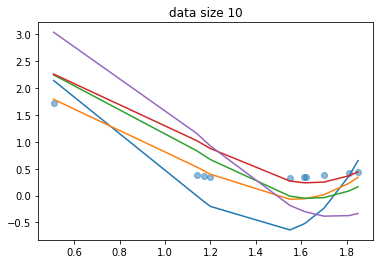

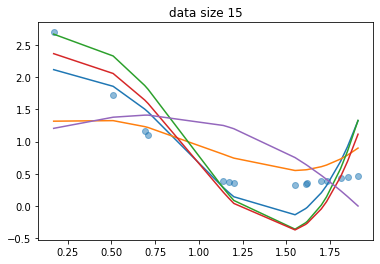

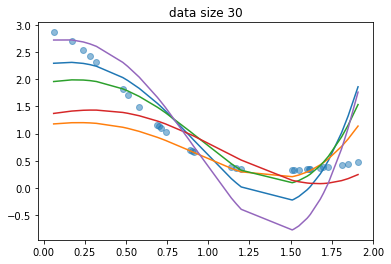

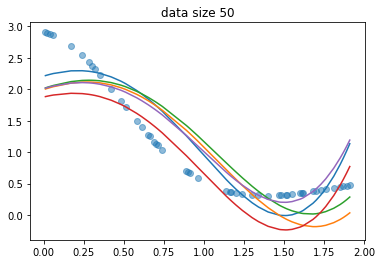

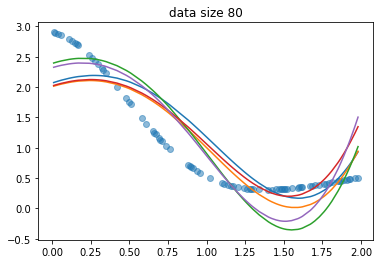

In [16]:
N_list = [10, 15, 30, 50, 80]
# N_list = [10]
for N in N_list:
    RM = RegressionModel()
    x = data['x'][:N]
    t = data['t'][:N]

    mN, SN = RM.posterior_distrib(x, t)
    w = multivariate_normal(mean=mN.reshape(RM.M), cov=SN).rvs(size=5)

    plt.scatter(x, t, alpha = 0.5)
    
    x = np.array(sorted(x))

    for _w in w:
        y = RM.predict(_w, RM.basis_function(x).T)
        plt.title('data size %d' % N)
        plt.plot(x, y, '-')
    plt.show()